## Gerando uma lista de motion words para uma atividade

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import string
import Levenshtein as l
%matplotlib inline
sys.path.insert(1, r'./functions')  # add dir to pythonpath
from detect_peaks import detect_peaks
from collections import defaultdict


In [2]:
def gen_iaam(data, jointdofset,
             minpeakdist=5,
             minpeakheight=-180,
             amplimjoint=15,
             simult_lim=5,
             display=False):
    """ determina os ponto de particão do intervalo em
    subintervalos IAAM

        Parameters
        ----------
        data : ndarray, uma coluna para cada DOF, uma linha para cada
        frame, dtype indicando os labels

        jointdofset : list, uma lista com os labels dos DOF de interesse

        minpeakheight : {None, number}, optional (default = -180
            A etapa de detecção de picos, se restringe a picos maiores
            que minpeakheight

        minpeakdist : positive integer, optional (default = 5
            A etapa de detecção de picos, se restringe a picos que estão
            separados de pelo menos minPeakDistance amostras

        amplimjoint : positive number, optional (default = 15)
            Entre dois pontos de partição a diferença de amplitude é de
            pelo menos amplimjoint

        simult_lim: = positive number, optional (default = 3)
            Pontos que ocorrem em instântes a menos de 3 frames de diferença
            são considerados simultanêos e somente o primeiro é considerado

        display: bool, optional (default = False)
            if True (1), plot data in matplotlib figure.

        Returns
        -------
        ind : 1D array_like
            indices dos pontos de partição do intervalo
    """

    multsigpoints = np.array([], dtype='int64')

    if display:
        plt.subplots(1, sharex=True, figsize=(6, 6))

    for dof in jointdofset:
        curve = data[dof]
        valleys = detect_peaks(curve, mph=minpeakheight, mpd=minpeakdist, valley=True, edge='both')
        peaks = detect_peaks(curve, mph=minpeakheight, mpd=minpeakdist, edge='both')
        peaksandvalleys = np.union1d(valleys, peaks)
        peaksandvalleys = np.insert(peaksandvalleys, [0], 0)
        peaksandvalleys = np.append(peaksandvalleys, [curve.size - 1])

        ampsignalpoints = np.array([], dtype='int64')
        first = peaksandvalleys[0]
        second = peaksandvalleys[1]
        for val in peaksandvalleys[2::]:
            third = val
            v1 = curve[first]
            v2 = curve[second]
            v3 = curve[third]
            if (np.abs(v1 - v2) > amplimjoint) or (np.abs(v2 - v3) > amplimjoint):
                ampsignalpoints = np.append(ampsignalpoints, second)
            first = second
            second = third

        ampsignalpoints = np.insert(ampsignalpoints, 0, 0)
        ampsignalpoints = np.append(ampsignalpoints, curve.size - 1)
        multsigpoints = np.union1d(multsigpoints, ampsignalpoints)
        nframes = np.shape(data)[0]
        frames = np.linspace(1, nframes, nframes)
        if display:
            plt.plot(frames, curve, label=dof, lw=1)
            plt.plot(frames[ampsignalpoints], curve[ampsignalpoints], 'bo')
            plt.plot(frames[peaksandvalleys], curve[peaksandvalleys], 'rx')

    partitionpoints = np.array([multsigpoints[0]], dtype='int64')

    for sigPoint in multsigpoints[1::]:
        if (sigPoint - partitionpoints[-1]) > simult_lim:
            partitionpoints = np.append(partitionpoints, sigPoint)

    if display:
        for finalSeg in partitionpoints:
            plt.axvline(x=finalSeg, ls='--')
        plt.legend(fontsize='medium')
        plt.xlabel('frames', fontsize=16)
        plt.ylabel('angulo articular(graus)', fontsize=16)      
       
        # plt.ylim((-40, 90))
        #plt.show()

    return partitionpoints

In [3]:
def int2base(x, base):
    digs = string.digits + string.ascii_letters
    if x < 0:
        sign = -1
    elif x == 0:
        return digs[0]
    else:
        sign = 1
    x *= sign
    digits = []
    while x:
        index = x % base
        digits.append(digs[index])
        x //= base
    if sign < 0:
        digits.append('-')
    digits.reverse()
    return ''.join(digits)

In [4]:
def gen_motion_word_int(data, joint_dof_set, var_levels, amp_lim_joint=15,
                        display=False):
    """
    :param amp_lim_joint:
    :param data: ndarray, uma coluna para cada DOF, uma linha para cada
           frame, dtype indicando os labels

    :param joint_dof_set: list, uma lista com os labels dos DOF de interesse, no máximo

    :param var_level: positive integer, optional (default = 10)
           calculamos a velocidade angular média(graus/segundos) no intervalo e comparamos
           com varLevel para determinar o estado do IAAM

    :param display: bool, optional (default = False)
            if True (1), plot data in matplotlib figure.

    :return: partition_points: 1D array_like
            indices dos pontos de partição do intervalo

    :return: motionWordInt: 1D array_like
            sequência de número correspondente a motion word

    """
    partition_points = gen_iaam(data, joint_dof_set, amplimjoint=amp_lim_joint,
                                display=display)
    motion_word_int = np.array([], dtype=int)
    pseg = 0
    for point in partition_points[1:]:
        symbol = 0;
        dofIndex = 0;
        for dof in joint_dof_set[::-1]:
            curve = data[dof]
            diff = curve[point] - curve[pseg]
            slope = diff * 120 / (1.0 * point - pseg)
            if np.abs(slope) > var_levels[dof]:
                if diff > 0:
                    symbol += 2 * (3 ** dofIndex)
                else:
                    symbol += 1 * (3 ** dofIndex)
            dofIndex += 1
        motion_word_int = np.append(motion_word_int, int(symbol))
        pseg = point
    labels_points = partition_points[0:-1] + (partition_points[1::] - partition_points[0:-1]) / 2.0
    mw_b3 = [int2base(c, 3) for c in motion_word_int]
    if display:
        for symb_int, symb_b3, lp in zip(motion_word_int, mw_b3, labels_points):
            plt.text(lp - 4, 40, symb_int, fontsize=10, color='purple')
            # plt.text(lp - 2, 55, chr(symb_int), fontsize=14, color='purple')
            plt.text(lp - 2, 55, symb_b3, fontsize=14, color='purple')
        plt.show()
    return partition_points, motion_word_int


In [5]:
Motions = [
    'walk2StepsLstart'
]

motionsDic = dict(zip(Motions, np.arange(1, np.size(Motions) + 1)))

selDofs = [
    'rhipjoint__rfemur_rx',  # hip
    'rfemur__rtibia_rx',  # knee
    'rtibia__rfoot_rx',  # ankle
]

var_levels = {
    'rhipjoint__rfemur_rx': 30,
    'rfemur__rtibia_rx': 25,
    'rtibia__rfoot_rx': 10,
    'lclavicle__lhumerus_rx': 30
}

motionFiles = []
db =[]

for motion in Motions:
    currentMoveFileList = glob.glob("./cleanNpyData/*" + motion + "*")
    currentLabels = [motion] * np.size(currentMoveFileList)
    currentEnumClass = [motionsDic[motion]] * np.size(currentMoveFileList)      
    motionFiles = motionFiles + currentMoveFileList
    
for file in motionFiles:
    data = np.load(file)
    [pIndex, wInt] = gen_motion_word_int(data, selDofs, var_levels, amp_lim_joint=5)
    wChar = ''.join([chr(cInt) for cInt in wInt])
    db.append(wInt)

In [6]:
len(db)

31

Temos um conjunto de 31 amostras associados a uma atividade especifica.

## Mineração de padrões sequências

Resolvemos o problema de mineração de padrões sequenciais por meio do algoritmo prefix-span implementado abaixo:

In [7]:


def mine_rec(patt, mdb):
    results.append((patt, len(mdb)))

    occurs = defaultdict(list)
    for (i, startpos) in mdb:
        seq = db[i]
        for j in range(startpos, len(seq)):
            l = occurs[seq[j]]
            if len(l) == 0 or l[-1][0] != i:
                l.append((i, j + 1))

    for (c, newmdb) in occurs.items():
        if len(newmdb) >= minsup:
            mine_rec(patt + [c], newmdb)

In [8]:
minsup = round(0.9*len(db))
results = []
mine_rec([], [(i, 0) for i in range(len(db))])

Padrões sequências com frequência superior a 90% :

In [9]:
results

[([], 31),
 ([13], 31),
 ([16], 31),
 ([16, 13], 31),
 ([17], 31),
 ([17, 13], 31),
 ([17, 16], 31),
 ([17, 16, 13], 31)]

A sequência [17, 16, 13] é uma das encontradas e ocorre 31 vezes, i.e. uma frequência de 100%. Podemos observar duas amostras como exemplos:

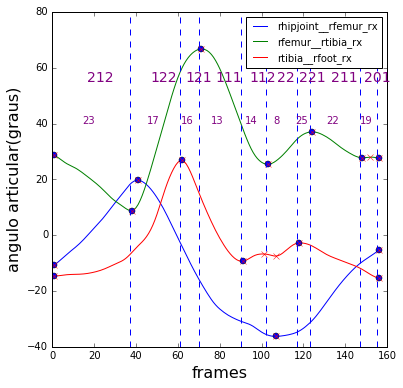

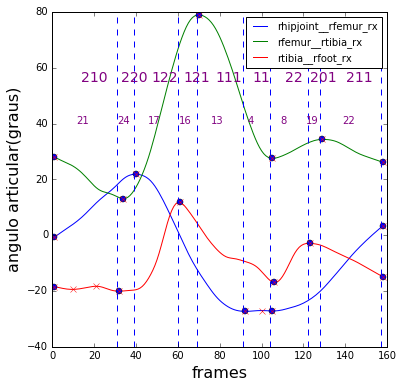

(array([  0,  31,  39,  60,  69,  91, 104, 122, 128, 157]),
 array([21, 24, 17, 16, 13,  4,  8, 19, 22]))

In [10]:
gen_motion_word_int(np.load(motionFiles[1]), selDofs, var_levels, display=True, amp_lim_joint=5)
gen_motion_word_int(np.load(motionFiles[6]), selDofs, var_levels, display=True, amp_lim_joint=5)